# Qiskit Algorithms Transition Guide

## Restructuring the applications

The Qiskit 0.25.0 release includes a restructuring of the algorithms. What previously has been referred to as Qiskit Aqua, the single application module of Qiskit, is now split into dedicated application modules for Optimization, Finance, Machine Learning and Nature (including Physics & Chemistry).

## Algorithm interfaces

Additionally to the restructuring, all algorithms follow a new unified paradigm: algorithms are classified according to the problems they solve, and within one application class algorithms can be used interchangeably to solve the same problem. This means that, unlike before, algorithm instances are decoupled from the problem they solve. We can summarize this in a flowchart:

<img src="algorithmflow.png" alt="Drawing" style="width: 1000px;"/>

For example, the variational quantum eigensolver, `VQE` is a `MinimumEigensolver` as it computes the minimum eigenvalue of an operator. The problem here is specified with the operator, whose eigenvalue we seek, while properties such as the variational ansatz circuit and classical optimizer are properties of the algorithm. That means the `VQE` has the following structure
```python
vqe = VQE(ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(operator)
```
We can exchange the `VQE` with any other algorithm that implements the `MinimumEigensolver` interface to compute the eigenvalues of your operator, e.g.
```
numpy_based = NumPyMinimumEigensolver()
classical_reference = numpy_based.compute_minimum_eigenvalue(operator)
```
This allows you to easily switch between different algorithms, check against classical references, and provide your own implementation -- you just have to implement the existing interface.

This notebook serves as migration guide to facilitate changing your current code using Qiskit Aqua to the new structure.

### Contents

1. [Quantum Instance](#qi)
1. [Operators](#h)
1. [Optimizers](#opt)
1. [Grover](#grover)
1. [Amplitude estimation](#ae)
1. [Minimum eigenvalues](#mes)
1. [(General) Eigenvalues](#es)
1. [Shor](#shor)
1. [HHL](#hhl)
1. [Phase Estimation](#pe)

# QuantumInstance<a id='qi' href='#'></a>

The `QuantumInstance` moved the import location from
```
qiskit.aqua.QuantumInstance
```
to 
```
qiskit.utils.QuantumInstance
```

**Previously:**

In [1]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance as AquaQuantumInstance

backend = Aer.get_backend('statevector_simulator')
aqua_qinstance = AquaQuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


**New:**

In [2]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

# Operators<a id='h' href='#'></a>

The Opflow operators moved from
```
qiskit.aqua.operators
```
to
```
qiskit.opflow
```

**Previously:**

In [3]:
from qiskit.aqua.operators import X, I, Y

op = (X ^ I) + (Y ^ 2)

/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


**New:**

In [4]:
from qiskit.opflow import X, I, Y

op = (X ^ I) + (Y ^ 2)

**Additional features:**

With `qiskit.opflow` we introduce a new, more efficient representation of sums of Pauli strings, which can significantly speed up computations on very large sums of Paulis. This efficient representation is automatically used if Pauli strings are summed:

In [5]:
op = (X ^ X ^ Y ^ Y) + (X ^ 4) + (Y ^ 4) + (I ^ X ^ I ^ I)
type(op)

qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp

# Optimizers<a id='op' href='#'></a>

The classical optimization routines changed locations from
```
qiskit.aqua.components.optimizers
```
to 
```
qiskit.algorithms.optimizers
```

**Previously:**

In [6]:
from qiskit.aqua.components.optimizers import SPSA

spsa = SPSA(maxiter=10)

/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


**New:**

In [7]:
from qiskit.algorithms.optimizers import SPSA

spsa = SPSA(maxiter=10)

# Grover<a href='#' id='grover'></a>

## Summary

The previous structure
```python
grover = Grover(oracle_settings, algorithm_settings)
result = grover.run()
```
is changed to split problem/oracle settings and algorithm settings, to
```python
grover = Grover(algorithm_settings)
problem = AmplificationProblem(oracle_settings)
result = grover.amplify(problem)
```
See the documentation of the [deprecated Grover](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.Grover.html#qiskit.aqua.algorithms.Grover) and [new Grover](#).

## Transition guide

For oracles provided as circuits and a `is_good_state` function to determine good states

In [8]:
from qiskit.circuit import QuantumCircuit

oracle = QuantumCircuit(2)
oracle.cz(0, 1)

def is_good_state(bitstr):
    return sum(map(int, bitstr)) == 2

**Previously:**

In [9]:
from qiskit.aqua.algorithms import Grover

grover = Grover(oracle, is_good_state, quantum_instance=aqua_qinstance)
result = grover.run()
print('Top measurement:', result.top_measurement)

/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/algorithms/amplitude_amplifiers/grover.py:216: DeprecationWarning: The package qiskit.aqua.algorithms.amplitude_amplifiers is deprecated. It was moved/refactored to qiskit.algorithms.amplitude_amplifiers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.amplitude_amplifiers', 'qiskit-terra')


Top measurement: 11


**New:**

In [10]:
from qiskit.algorithms import Grover, AmplificationProblem

problem = AmplificationProblem(oracle=oracle, is_good_state=is_good_state)
grover = Grover(quantum_instance=qinstance)
result = grover.amplify(problem)
print('Top measurement:', result.top_measurement)

Top measurement: 11


Since we are streamling all algorithms to use the `QuantumCircuit` class as base primitive, defining oracles using the `qiskit.aqua.compontents.Oracle` class is deprecated. Instead of using e.g. the `LogicalExpressionOracle` you can now use the `PhaseOracle` circuit from the circuit library.

**Previously:**

In [11]:
from qiskit.aqua.components.oracles import LogicalExpressionOracle
from qiskit.aqua.algorithms import Grover

oracle = LogicalExpressionOracle('x & ~y')
grover = Grover(oracle, quantum_instance=aqua_qinstance)
result = grover.run()
print('Top measurement:', result.top_measurement)

Top measurement: 01


**New:**

In [12]:
# from qiskit.circuit.library import PhaseOracle
# from qiskit.algorithms import Grover, AmplificationProblem

# oracle = PhaseOracle('x & ~y')
# problem = AmplificationProblem(oracle=oracle, is_good_state=oracle.is_good_state)
# grover = Grover(quantum_instance=qinstance)
# result = grover.amplify(problem)
# print('Top measurement:', result.top_measurement)

The `qiskit.aqua.components.oracles.TruthTableOracle` is not yet ported, but the behaviour can easily be achieved with the `qiskit.circuit.classicalfunction` module, see the tutorials on Grover's algorithm.

## More examples

In [13]:
# TBD

# Amplitude estimation<a href='#' id='ae'></a>

## Summary

For all amplitude estimation algorithms 
* `AmplitudeEstimation`
* `IterativeAmplitudeEstimation`
* `MaximumLikelihoodAmplitudeEstimation`, and
* `FasterAmplitudeEstimation`

the interface changed from
```python
qae = AmplitudeEstimation(algorithm_settings, estimation_settings)
result = qae.run()
```
to split problem/oracle settings and algorithm settings
```python
qae = AmplitudeEstimation(algorithm_settings)
problem = EstimationProblem(oracle_settings)
result = qae.amplify(problem)
```
See the documentation of the [deprecated amplitude estimation algorithms](https://qiskit.org/documentation/apidoc/qiskit.aqua.algorithms.html#amplitude-estimators) and [new ones](#).

Here, we'd like to estimate the probability of measuring a $|1\rangle$ in our single qubit.

## Transition guide

If the state preparation is provided as circuit

Target probability: 0.25


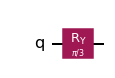

In [14]:
import numpy as np

probability = 0.25
rotation_angle = 2 * np.arcsin(np.sqrt(probability))

state_preparation = QuantumCircuit(1)
state_preparation.ry(rotation_angle, 0)

objective_qubits = [0]  # the good states are identified by qubit 0 being in state |1>

print('Target probability:', probability)

state_preparation.draw(output='mpl', style='iqx')

**Previously:**

In [15]:
from qiskit.aqua.algorithms import AmplitudeEstimation

# instantiate the algorithm and passing the problem instance
ae = AmplitudeEstimation(3, state_preparation, quantum_instance=aqua_qinstance)

# run the algorithm
result = ae.run()

# print the results
print('Grid-based estimate:', result.estimation) 
print('Improved continuous estimate:', result.mle)

Grid-based estimate: 0.1464466
Improved continuous estimate: 0.2499999956539467


/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/algorithms/amplitude_estimators/ae_algorithm.py:92: DeprecationWarning: The package qiskit.aqua.algorithms.amplitude_estimators is deprecated. It was moved/refactored to qiskit.algorithms.amplitude_estimators (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.amplitude_estimators', 'qiskit-terra')


**Now:**

In [16]:
from qiskit.algorithms import AmplitudeEstimation, EstimationProblem

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=objective_qubits)
ae = AmplitudeEstimation(num_eval_qubits=3, quantum_instance=qinstance)

result = ae.estimate(problem)
print('Grid-based estimate:', result.estimation) 
print('Improved continuous estimate:', result.mle)

Grid-based estimate: 0.1464466
Improved continuous estimate: 0.2499999956513743


Note that the old class used the last qubit in the `state_preparation` as objective qubit as default, if no other indices were specified. This default does not exist anymore to improve transparency and remove implicit assumptions.

## More examples

To construct the circuit for amplitude estimation, we can do

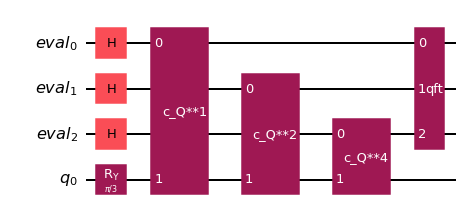

In [17]:
ae.construct_circuit(estimation_problem=problem).draw('mpl', style='iqx')

Now that the problem is separated from the algorithm we can exchange `AmplitudeEstimation` with any other algorithm that implements the `AmplitudeEstimator` interface.

In [18]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(epsilon_target=0.01, alpha=0.05, quantum_instance=qinstance)

result = iae.estimate(problem)
print('Estimate:', result.estimation)

Estimate: 0.24999999999999994


In [19]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(evaluation_schedule=[0, 2, 4], quantum_instance=qinstance)

result = mlae.estimate(problem)
print('Estimate:', result.estimation)

Estimate: 0.2500081904035319


# Minimum eigenvalues<a href='#' id='mes'></a>

## Summary

The interface remained mostly the same, but where previously it was possible to pass the operator in the initializer 

Also the operators must now be constructed with operators from `qiskit.opflow` instead of `qiskit.aqua.operators`.

## Transition guide

Assume we want to find the minimum eigenvalue of 
$$
H = Z \otimes I.
$$

### NumPy-based eigensolver

**Previously:**

Previously we imported the operators from `qiskit.aqua.operators`:

In [20]:
from qiskit.aqua.operators import Z, I

observable = Z ^ I

and then solved for the minimum eigenvalue using

In [21]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver

mes = NumPyMinimumEigensolver()
result = mes.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-1+0j)


/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


It used to be possible to pass the observable in the initializer, which is now not allowed anymore due to the problem-algorithm separation.

In [22]:
mes = NumPyMinimumEigensolver(observable)
result = mes.compute_minimum_eigenvalue()
print(result.eigenvalue)

(-1+0j)


**Now:**

Now we need to import from `qiskit.opflow` but the other syntax remains exactly the same:

In [23]:
from qiskit.opflow import Z, I

observable = Z ^ I 

In [24]:
from qiskit.algorithms import NumPyMinimumEigensolver

mes = NumPyMinimumEigensolver()

result = mes.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-1+0j)


### VQE

The same changes hold for VQE. Let's use the `RealAmplitudes` circuit as ansatz:

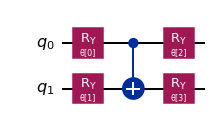

In [25]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(2, reps=1)
ansatz.draw(output='mpl', style='iqx')

**Previously:**

Previously, we had to import both the optimizer and operators from Qiskit Aqua:

In [26]:
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.operators import Z, I

observable = Z ^ I

vqe = VQE(var_form=ansatz, optimizer=COBYLA(), quantum_instance=aqua_qinstance)
result = vqe.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-0.9999999895599662+0j)


/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/algorithms/vq_algorithm.py:72: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/algorithms/quantum_algorithm.py:46: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.aqua_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  return aqua_globals.random


**Now:** 

Now we import optimizers from `qiskit.algorithms.optimizers` and operators from `qiskit.opflow`.

In [27]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import Z, I

observable = Z ^ I

vqe = VQE(var_form=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
result = vqe.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

-0.9999999926154866


Note that the `qiskit.aqua.components.variational_forms` are completely deprecated in favor of circuit objects. Most variational forms have already been ported to circuit library in previous releases and now also `UCCSD` is part of the Qiskit Nature's circuit library:

In [28]:
# from qiskit_nature.mappers.second_quantization import JordanWignerMapper
# from qiskit_nature.circuit.library import UCCSD

# circuit = UCCSD(JordanWignerMapper(), 4, 2)
# circuit.draw('mpl', style='iqx')

### QAOA

For Hamiltonians from combinatorial optimization (like ours: $Z \otimes I$) we can use the QAOA algorithm.

**Previously:**

In [29]:
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.operators import Z, I

observable = Z ^ I

qaoa = QAOA(optimizer=COBYLA(), quantum_instance=aqua_qinstance)
result = qaoa.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-0.9999999639262055+0j)


/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/components/variational_forms/variational_form.py:48: DeprecationWarning: The package qiskit.aqua.components.variational_forms is deprecated. For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.components.variational_forms')


**Now:**

In [30]:
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import Z, I

observable = Z ^ I

qaoa = QAOA(optimizer=COBYLA(), quantum_instance=qinstance)
result = qaoa.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

-0.999999979274729


### More examples

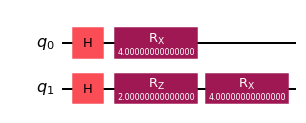

In [31]:
qaoa.construct_circuit([1, 2], observable)[0].draw(output='mpl', style='iqx')

# (General) Eigenvalues <a href='#' id='es'></a>

Currently, only NumPy-based calculations are available, but more algorithms will be available in the chemistry package.

As for the `MinimumEigenSolver`, the only change for the `EigenSolver` is the type for the observable and the import path.

**Previously:**

In [32]:
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.aqua.operators import I, Z

observable = Z ^ I

es = NumPyEigensolver(k=3)  # get the lowest 3 eigenvalues

result = es.compute_eigenvalues(observable)
print(result.eigenvalues)

[-1.+0.j -1.+0.j  1.+0.j]


**Now:**

In [33]:
from qiskit.algorithms import NumPyEigensolver
from qiskit.aqua.operators import I, Z

observable = Z ^ I

es = NumPyEigensolver(k=3)  # get the lowest 3 eigenvalues

result = es.compute_eigenvalues(observable)
print(result.eigenvalues)

[-1.+0.j -1.+0.j  1.+0.j]


# Shor's algorithm<a href='#' id='shor'></a>

## Summary

The arguments `N` and `a` moved from the initializer to the `Shor.factor` method.

We'll be using a shot-based readout for speed here.

In [34]:
aqua_qasm_qinstance = AquaQuantumInstance(Aer.get_backend('qasm_simulator'))
qasm_qinstance = QuantumInstance(Aer.get_backend('qasm_simulator'))

**Previously:**

In [35]:
from qiskit.aqua.algorithms import Shor

shor = Shor(N=15, a=2, quantum_instance=aqua_qinstance)

# result = shor.run()
# print('Factors:', result.factors)

/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/algorithms/factorizers/shor.py:71: DeprecationWarning: The package qiskit.aqua.algorithms.factorizers is deprecated. It was moved/refactored to qiskit.algorithms.factorizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


**New:**

In [36]:
from qiskit.algorithms import Shor

# shor = Shor(quantum_instance=qinstance)

# result = shor.factor(N=15, a=3)
# print('Factors:', result.factors)

## HHL<a href='#' id='hhl'></a>

HHL has been completely refactored to allow an intuitive interface and return an efficient, circuit-based representation of the result. 

Assume we want to solve the following linear system
$$
\begin{pmatrix}
1 & -1/3 \\
-1/3 & 1 \\
\end{pmatrix}
\vec x
=
\begin{pmatrix}
1 \\ 0
\end{pmatrix}
$$

In [37]:
import numpy as np

matrix = np.array([[1, -1/3], [-1/3, 1]])
vector = np.array([1, 0])

**Previously:**

In [38]:
from qiskit.circuit.library import QFT
from qiskit.aqua.algorithms import HHL
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.components.initial_states import Custom
from qiskit.aqua.operators import MatrixOperator

def create_eigs(matrix, num_auxiliary, num_time_slices, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_auxiliary += 1
        ne_qfts = [QFT(num_auxiliary - 1), QFT(num_auxiliary - 1).inverse()]
    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_auxiliary).inverse(),
                   num_time_slices=num_time_slices,
                   num_ancillae=num_auxiliary,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None, 
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

orig_size = len(vector)

matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, 50, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)
algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)

result = algo.run(aqua_qinstance)
print(result.solution)

/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/components/initial_states/custom.py:79: DeprecationWarning: The Custom class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits accept a plain QuantumCircuit. Custom(state_vector=vector) is the same as a circuit where the ``initialize(vector/np.linalg.norm(vector))`` method has been called.
  super().__init__()
/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/components/initial_states/custom.py:151: DeprecationWarning: The StateVectorCircuit class is deprecated as of Qiskit Aqua 0.9.0 and will be removed no earlier than 3 months after the release. If you need to initialize a circuit, use the QuantumCircuit.initialize or QuantumCircuit.isometry methods. For a parameterized initialization, try the qiskit.ml.circuit.library.RawFeatureVector class.
  svc = StateVectorCircuit(self._state_vector)


[ 0.66575607-5.39389682e-15j -0.38561455+4.35672537e-15j]


**Now:**

In [39]:
# from qiskit.algorithms import HHL

# hhl = HHL()
# result = hhl.solve(matrix, vector)
# result.state.draw('mpl', style='iqx')

Note that the solution vector is not returned, since that would require an exponentially expensive simulation of the solution circuit. Instead, the circuit can be used to evaluate observables on the solution. For details, see the documentation and docstrings of HHL.

### NumPy-based linear solver

**Previously:**

In [40]:
from qiskit.aqua.algorithms import NumPyLSsolver

ls = NumPyLSsolver(matrix, vector)
result = ls.run()
print(result.solution)

[1.125, 0.375]


**Now:**

In [41]:
# from qiskit.algorithms import NumPyLinearSolver

# ls = NumPyLinearSolver()
# result = ls.solve(matrix, vector)
# print(result.state)

## Phase estimation<a href='#' id='pe'></a>

Let's consider the problem of finding the eigenvalue of

$$
H = 0.5 X + Y + Z
$$
with the input state $|0\rangle$.

In [42]:
state_in = np.array([1, 0])

**Previously:**

In [43]:
from qiskit.circuit.library import QFT
from qiskit.aqua.algorithms import QPE
from qiskit.aqua.components.initial_states import Custom
from qiskit.aqua.operators import I, X, Y, Z

n_ancillae = 5
num_time_slices = 1

op = 0.5 * X + Y + Z

# state_in = Custom(op.num_qubits, state_vector=eigenvector)
# iqft = QFT(n_ancillae, do_swaps=False).inverse().reverse_bits()

# qpe = QPE(op, state_in, iqft, num_time_slices, n_ancillae,
#          expansion_mode='trotter', 
#          shallow_circuit_concat=True)


#result = qpe.run(aqua_qinstance)

# print(result.eigenvalue)

**New:**

In [44]:
from qiskit import BasicAer
from qiskit.algorithms import HamiltonianPhaseEstimation
from qiskit.opflow import I, X, Y, Z, StateFn, PauliTrotterEvolution, Suzuki

# state_preparation = StateFn(eigenvector)

op = 0.5 * X + Y + Z

evolution = PauliTrotterEvolution()

qpe = HamiltonianPhaseEstimation(5, quantum_instance=qinstance)
# result = qpe.estimate(op, state_preparation)

# print(result.most_likely_eigenvalue)